In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import pylab as plt
%matplotlib inline
import torchvision.utils as vutils
import glob
import torch.nn.functional as F
import seaborn as sns
import copy
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
import sys
sys.path.append('../')
import models
import models.mnist
from data import get_loaders
from utils import DictWrapper

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
%aimport log_plotter
from log_plotter import get_run_names, get_data, get_data_pth, plot_smooth, plot_tag, plot_runs_and_tags, get_legend, plot_smooth_o1

In [5]:
logdir = '/u/faghri/dmom/code/runs/X/'
data = torch.load(logdir+'data.pth.tar', map_location='cpu')
checkpoint = torch.load(logdir+'checkpoint.pth.tar', map_location='cpu')

In [6]:
trainX, trainY, testX, testY, C = data

In [7]:
checkpoint['gvar']['gluster.assign_i'].shape

(640, 1)

In [8]:
checkpoint['gvar']['gluster.cluster_size'].shape

torch.Size([2, 1])

In [51]:
plt.rcParams.update({'font.size': 14})
# sns.set_palette('colorblind')
sns.set_color_codes('colorblind')

In [15]:
def draw_model(model, X, colors='black', ls='--'):
    x = np.linspace(X[0].min()-1, X[0].max()+1, 1000)
    y = np.linspace(X[1].min()-1, X[1].max()+1, 1000)
    px, py = np.meshgrid(x, y)
    p = np.vstack((px.flat, py.flat))

    Z = np.argmax(model(Variable(torch.Tensor(p.T))).data.numpy().copy(), axis=1)
    
    if ls == '-':
        plt.contourf(x, y, Z.reshape(1000, 1000), int(Z.max())+1, alpha=0.1, cmap=plt.cm.gray)
    plt.contour(x, y, Z.reshape(1000, 1000), colors=colors, linestyles=ls)
    # plt.scatter(C[0, :], C[1, :], c='g', s=100, label='centers')

In [11]:
def draw_grad(model, grad, lr, X, colors):
    model_new = copy.deepcopy(model)
    with torch.no_grad():
        for p, g in zip(model_new.parameters(), grad):
            p.add_(-g*lr)
    draw_model(model_new, X, colors)

In [44]:
def f(prefix, niter=0, perm=None, n_samples=-1, fname='fig.png'):
    prefix = prefix + '/'
    data=torch.load(prefix+'data.pth.tar', map_location='cpu')

    X, Y, Xt, Yt, C = data

    X.shape

    num = X.shape[1]

    # sample = np.random.choice(num, 1000, replace=False)
    sample = np.arange(num)

    checkpoint = torch.load(prefix+'checkpoint.pth.tar', map_location='cpu')
    assign_i = checkpoint['gvar']['gluster.assign_i']
    cluster_size = checkpoint['gvar']['gluster.cluster_size']
    n_clusters = cluster_size.shape[0]
    state_dict = checkpoint['model']

    C.shape

    model = models.logreg.Linear(C.shape[0], C.shape[1])
    model.load_state_dict(state_dict)
    
    draw_model(model, X, ls='-')

    ecol = ['b', 'r', 'g', 'm', 'c']
    col = ecol
    if perm is not None:
        col = [ecol[perm[i]] for i in range(len(perm))]
    # mark = ['o', 's']
    # mark = ['+', 'x']
    mark = ['o', 'x']
    for i in range(n_clusters):
        s = np.maximum(1, i/n_clusters*100)
        # print(s)
        ids = sample[assign_i[sample, 0]==i]
        if n_samples != -1:
            ids = ids[:n_samples]
        # ec = ['Red', 'Blue']
        # plt.scatter(
        #     X[0, ids],
        #     X[1, ids], c=col[i])
        
        for j in range(int(Y.max())+1):
            kwargs = {}
            if mark[j] != 'x':
                kwargs['edgecolors'] = col[i]
                kwargs['c'] = 'None'
            else:
                kwargs['c'] = col[i]
                kwargs['edgecolors'] = 'None'
            plt.scatter(
                X[0, ids[Y[ids]==j]],
                X[1, ids[Y[ids]==j]], marker=mark[j], s=70, linewidth=2, **kwargs)  # , facecolors='none')
                # edgecolors=ec[j])
                # c=1, s=1, cmap='Reds', edgecolors='Black')
                
        pred = model(torch.Tensor(X[:, ids]).t())
        loss = F.nll_loss(pred, torch.Tensor(Y[ids]).long())
        grad = torch.autograd.grad(loss, model.parameters())
        draw_grad(model, grad, 0.1, X, col[i])
        # print(grad)
    plt.axis('off')
    # plt.xlabel('Dimension 1')
    # plt.ylabel('Dimension 2')
    # plt.title('Step: %d' % niter)
    # plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    plt.savefig(prefix+fname, dpi=100, bbox_inches='tight', pad_inches=0.05)

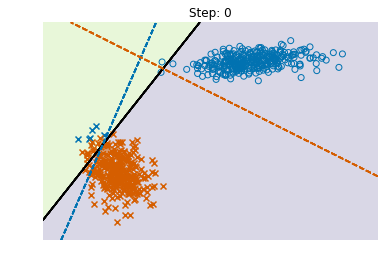

In [324]:
f('../runs/X')

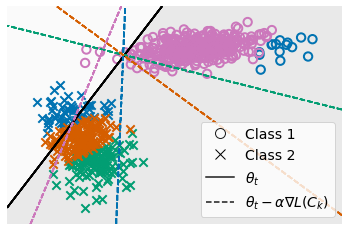

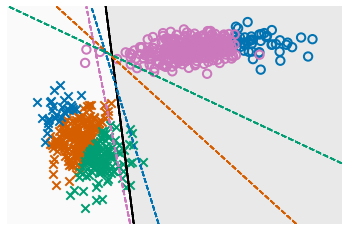

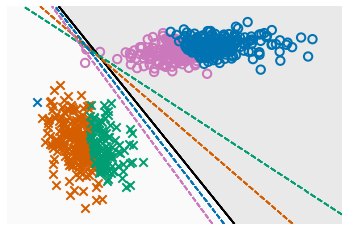

In [57]:
logdir='../runs/runs_logreg_2dvis/'
run_names=[]
for i in ['00', '01', '02']:
    run_names += glob.glob('%s/%s*' % (logdir, i))
niters = [0, 1, 2]
perm = [[0, 2, 1, 3], [1, 0, 3, 2], [1, 2, 3, 0]]
for i in range(len(run_names)):
    fig = plt.figure()
    # plt.tight_layout(pad=0)
    # ax = plt.axes([0,0,1,1])
    # ax.set_axis_off()
    # fig.add_axes(ax)
    # fig.patch.set_visible(False)
    if i == 0:
        legend_elements = [Line2D([0], [0], marker='o', color='None', label='Class 1',
                              markerfacecolor='None', markeredgecolor='k', markersize=10),
                           Line2D([0], [0], marker='x', color='None', label='Class 2',
                              markerfacecolor='k', markersize=10),
                           Line2D([0], [0], color='k', label=r'$\theta_t$'),
                           Line2D([0], [0], color='k', label=r'$\theta_t-\alpha\nabla L(C_k)$', ls='--'),
                           # Patch(facecolor='b', edgecolor='None', label='Gluster 1'),
                           # Patch(facecolor='r', edgecolor='None', label='Gluster 2'),
                          ]
        plt.legend(handles=legend_elements, loc='lower right')
    f(run_names[i], niter=niters[i], perm=perm[i], fname='fig.png')

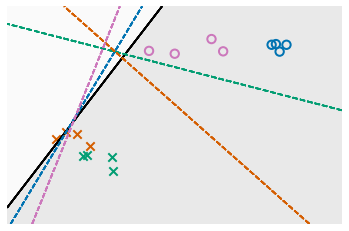

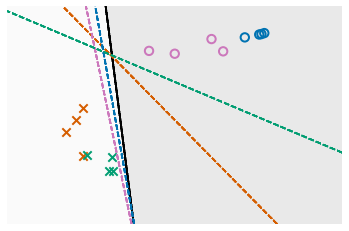

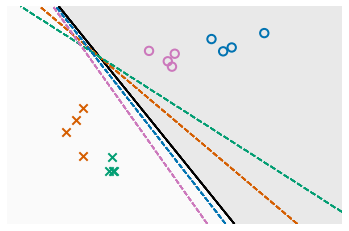

In [55]:
logdir='../runs/runs_logreg_2dvis/'
run_names=[]
for i in ['00', '01', '02']:
    run_names += glob.glob('%s/%s*' % (logdir, i))
niters = [0, 1, 2]
perm = [[0, 2, 1, 3], [1, 0, 3, 2], [1, 2, 3, 0]]
for i in range(len(run_names)):
    fig = plt.figure()
    # plt.tight_layout(pad=0)
    # ax = plt.axes([0,0,1,1])
    # ax.set_axis_off()
    # fig.add_axes(ax)
    # fig.patch.set_visible(False)
    f(run_names[i], niter=niters[i], perm=perm[i], n_samples=4, fname='fig_sampled.png')